In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys
from functools import reduce
import warnings
warnings.simplefilter(action='ignore')
%matplotlib inline

In [2]:
# get data and generate necessary time features
def get_data(year = ''):
    if sys.platform == 'win32':
        data = pd.read_csv('C:/Users/liumh/OneDrive/two-sigma/data/' + year + '.csv.gz')
    if sys.platform == 'linux':
        data = pd.read_csv('../data/' + year + '.csv.gz')
    data.time = pd.to_datetime(data.time)  
    data.sort_values('time', inplace = True)
    data['date'] = data.time.dt.date       
    data.sort_values('time', inplace = True)
    return data

In [3]:
data2017 = get_data(year = '2017')
data2017.shape,
data2017.head()

((7466025, 11),)

,time,ca,unit,scp,station,linename,division,desc,entries,exits,date
0,2017-01-01,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992418.0,2028543.0,2017-01-01
2,2017-01-01,A002,R051,02-03-00,59 ST,NQR456W,BMT,REGULAR,842188.0,3132405.0,2017-01-01
3,2017-01-01,A002,R051,02-03-01,59 ST,NQR456W,BMT,REGULAR,123036.0,218034.0,2017-01-01
4,2017-01-01,A002,R051,02-03-02,59 ST,NQR456W,BMT,REGULAR,5210075.0,7206414.0,2017-01-01
5,2017-01-01,A002,R051,02-03-03,59 ST,NQR456W,BMT,REGULAR,4847483.0,5782003.0,2017-01-01


## Q1. What is the total number of entries across the subway system for August 1, 2017?

### 1.1 calculate daily entry for each turnstile on 1 August 2017   
ca and scp together defines single turnstile uniquely 

In [4]:
# get data on 1 August 2017
subset = data2017[['ca','scp','time','entries']][(data2017.time >= pd.to_datetime('2017-08-01')) & (data2017.time <= pd.to_datetime('2017-08-02'))]
# calculate daily entry
subset.sort_values(['time'], inplace = True)
daily_entry = subset.groupby(['ca','scp']).nth(-1).entries - subset.groupby(['ca','scp']).nth(0).entries
daily_entry = daily_entry.reset_index()

In [5]:
daily_entry.describe()

,entries
count,4.678000e+03
mean,1.519084e+04
std,9.809778e+05
min,-8.910600e+05
25%,3.080000e+02
50%,8.800000e+02
75%,1.556000e+03
max,6.708973e+07


### 1.2 Handling negative values and outliers
The above daily entry statistics shows that there are negative values and outliers in the dataset. Let's try to understand this and figure out a proper solution. 

The below descriptive statistics for negative and non-negative entries have comparable magnitudes.

In [6]:
print('non-negative entries')
daily_entry[daily_entry.entries >= 0].entries.describe(percentiles = [0.1, 0.5, 0.9])
print('negative entries')
daily_entry[daily_entry.entries < 0].entries.describe(percentiles = [0.1, 0.5, 0.9])

non-negative entries


count    4.639000e+03
mean     1.553941e+04
std      9.850019e+05
min      0.000000e+00
10%      0.000000e+00
50%      8.880000e+02
90%      2.350400e+03
max      6.708973e+07
Name: entries, dtype: float64

negative entries


count        39.000000
mean     -26271.333333
std      142307.802109
min     -891060.000000
10%       -4428.800000
50%       -2456.000000
90%        -691.200000
max        -256.000000
Name: entries, dtype: float64

(-2000, 2000)

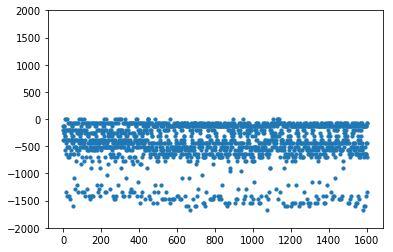

(-2000, 2000)

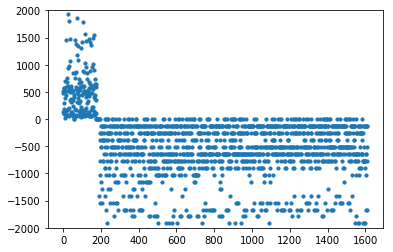

(-2000, 2000)

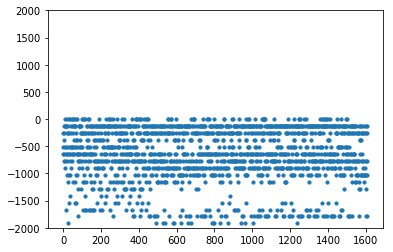

(-2000, 2000)

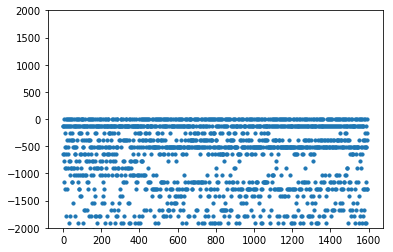

(-2000, 2000)

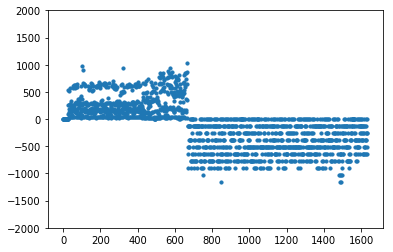

(-2000, 2000)

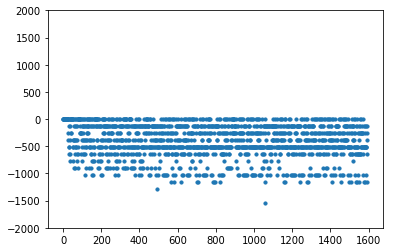

(-2000, 2000)

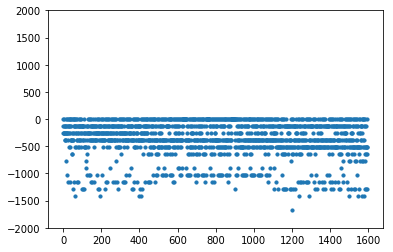

(-2000, 2000)

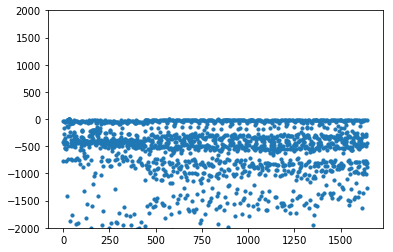

(-2000, 2000)

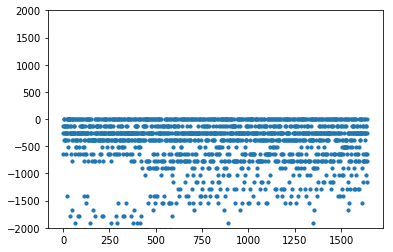

(-2000, 2000)

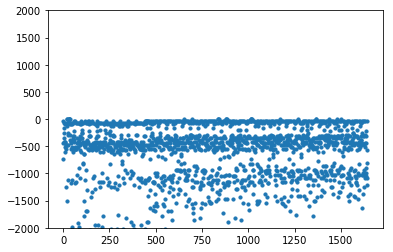

(-2000, 2000)

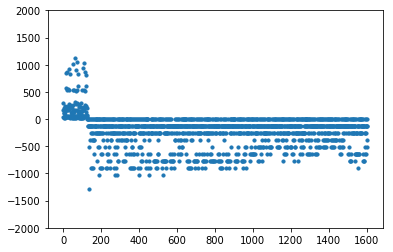

(-2000, 2000)

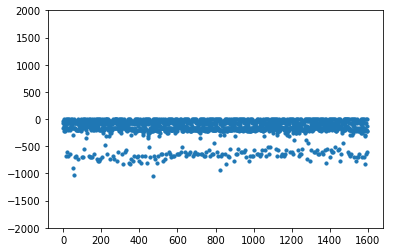

(-2000, 2000)

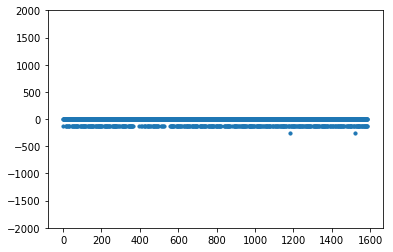

(-2000, 2000)

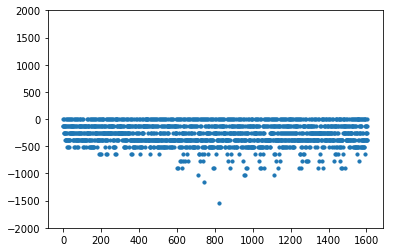

(-2000, 2000)

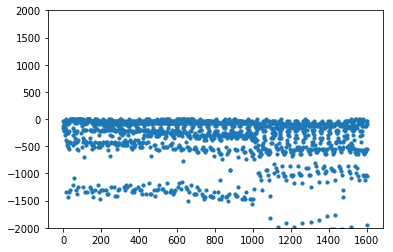

(-2000, 2000)

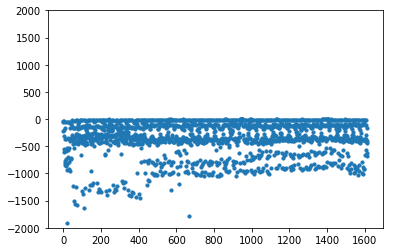

(-2000, 2000)

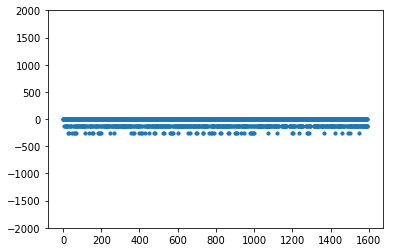

(-2000, 2000)

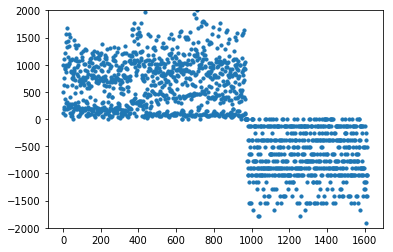

(-2000, 2000)

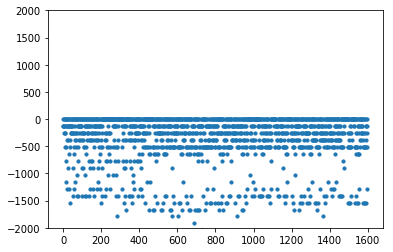

(-2000, 2000)

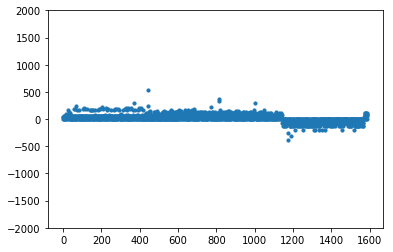

(-2000, 2000)

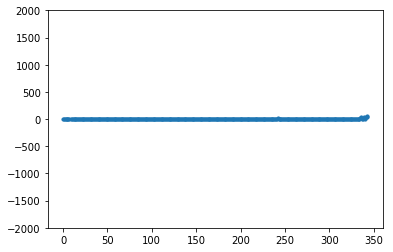

(-2000, 2000)

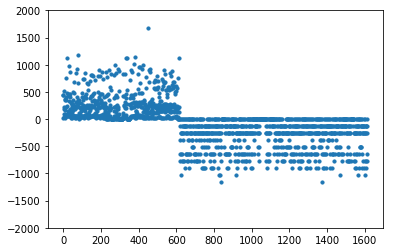

(-2000, 2000)

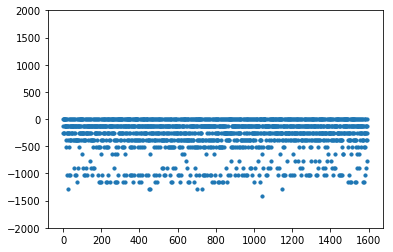

(-2000, 2000)

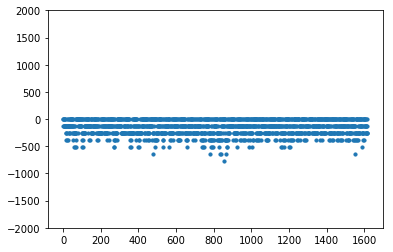

(-2000, 2000)

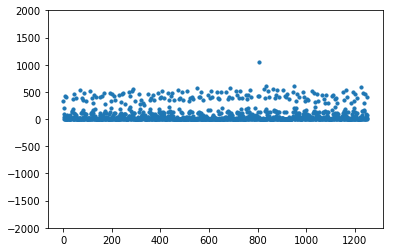

(-2000, 2000)

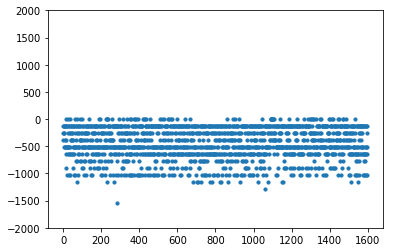

(-2000, 2000)

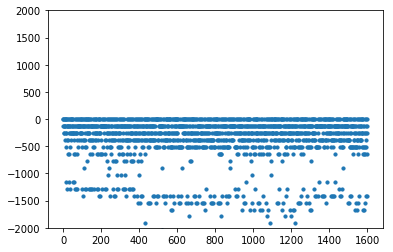

(-2000, 2000)

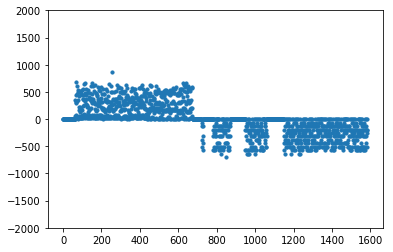

(-2000, 2000)

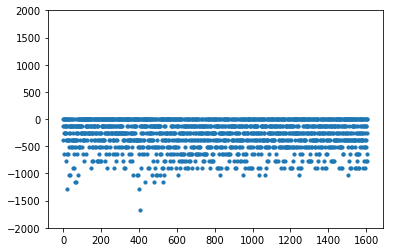

(-2000, 2000)

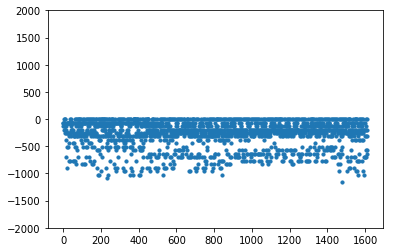

(-2000, 2000)

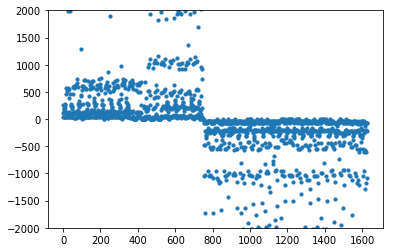

(-2000, 2000)

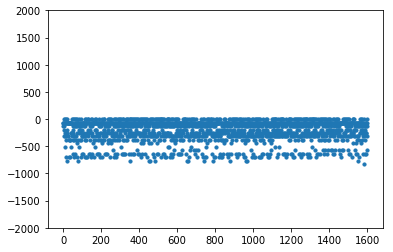

(-2000, 2000)

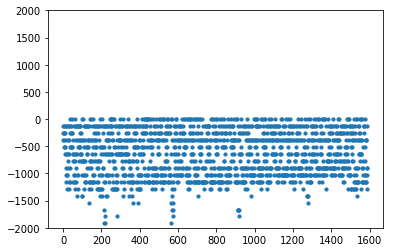

(-2000, 2000)

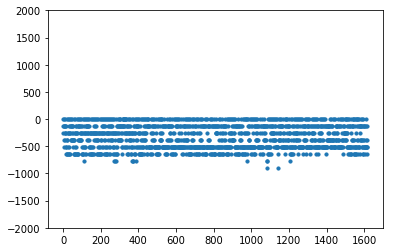

(-2000, 2000)

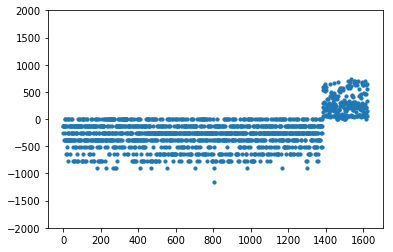

(-2000, 2000)

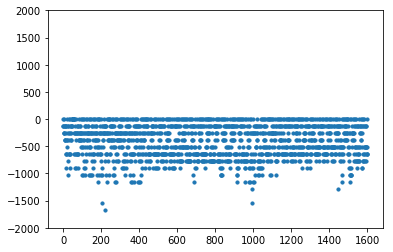

(-2000, 2000)

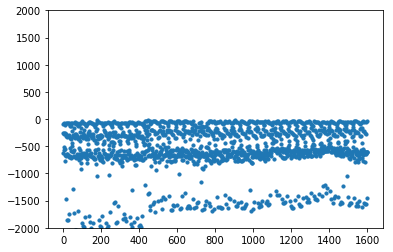

(-2000, 2000)

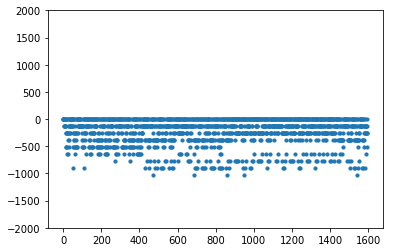

(-2000, 2000)

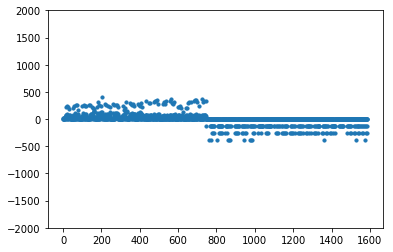

In [7]:
# for turstiles with negative entries, plot their daily entries in 2017
negative_turnstiles = daily_entry[['ca', 'scp']][daily_entry.entries < 0]
for i in range(negative_turnstiles.shape[0]):
    ca_i = negative_turnstiles.iloc[i,:][0]
    scp_i = negative_turnstiles.iloc[i,:][1]
    sub = data2017[(data2017.ca == ca_i) & (data2017.scp == scp_i)].entries.diff().shift(-1)
    plt.ylim([-2000,2000])
    _ = plt.scatter(range(sub.shape[0]), sub, s = 10)
    plt.show()

1. It seems that for some turnstiles, there is no positive entires and for some other turnstiles, the entries changes its sign more than once.
Combining the visulization and descriptive statistics results, I think some system errors cause negative entries by counting new entries as -1. To solve this problem, we can take absolute value of all entries.
2. If we don't set the ylim, we can see extremely large values. This may due to system error and we should remove these outliers.

In [8]:
#########################  Functions for calculating daily entries and exits   ##################################

def get_daily_data(data, start_date = datetime.datetime(2010,4,17), end_date = datetime.datetime(2017,9,23)):
    '''
    This function calculates daily entries and exits
    1. create a dataframe for all turnstiles and days between start date and end date
    2. sort data to be in ascending time order
    3. merge first record of each unique combinations of ['ca','scp','date'] with this dataframe and calculate daily data. 
       In this way, only adjacent dates will be used for calculating daily data. 
    4. Each day's data record should starts at 00:00:00, for days with first record after 4am, remove these days 
    '''
    ca_scp = data.ca + '_' + data.scp
    ca_scp = ca_scp.unique()
    
    dates = pd.date_range(start_date, end_date)
    dates = pd.DataFrame(dates)
    dates.columns = ['date']
    dates.date = dates.date.dt.date
    
    dfs = []
    for item in ca_scp:
        df = dates.copy()
        df['ca'] = item.split('_')[0]
        df['scp'] = item.split('_')[1]
        dfs.append(df)
    daily_data = pd.concat(dfs)
    daily = data.groupby(['ca','scp','date']).nth(0)
    daily = daily.reset_index()
    
    # each day starts at 00:00:00, so only keep days with first record before 4am
    daily['hour'] = daily.time.dt.hour
    daily.loc[daily.hour >= 4, ['entries', 'exits']] = np.nan
    daily_data = daily_data.merge(daily, how = 'left', on = ['ca','scp','date'])
    daily_data.entries = daily_data[['ca', 'scp', 'entries']].groupby(['ca', 'scp']).entries.apply(lambda x: x.diff().shift(-1).abs())
    daily_data.exits = daily_data[['ca', 'scp', 'exits']].groupby(['ca', 'scp']).exits.apply(lambda x: x.diff().shift(-1).abs())
    return daily_data

def filter_data(df):
    '''
    define outliers as values beyond 5*IQR and set outliers to np.nan, which will be removed later
    '''
    cols = ['ca', 'scp', 'entries', 'exits']
    Q1 = df[cols].groupby(['ca', 'scp']).quantile(0.1)
    Q3 = df[cols].groupby(['ca', 'scp']).quantile(0.9)
    IQR = Q3 - Q1
    Q1.columns = ['entries_Q1', 'exits_Q1']
    Q3.columns = ['entries_Q3', 'exits_Q3']
    IQR.columns = ['entries_IQR', 'exits_IQR']
    Q1 = Q1.reset_index()
    Q3 = Q3.reset_index()
    IQR = IQR.reset_index()
    dfs = [df, Q1, Q3, IQR]
    df = reduce(lambda left, right: pd.merge(left, right, how = 'left', on = ['ca', 'scp']), dfs)
    df['entries'][(df.entries < (df.entries_Q1 - 5 * df.entries_IQR)) 
                                           | (df.entries > (df.entries_Q3 + 5 * df.entries_IQR))] = np.nan
    df['exits'][(df.exits < (df.exits_Q1 - 5 * df.exits_IQR)) 
                                           | (df.exits > (df.exits_Q3 + 5 * df.exits_IQR))] = np.nan
    cols = ['entries_Q1', 'exits_Q1', 'entries_Q3', 'exits_Q3', 'entries_IQR', 'exits_IQR']
    df.drop(cols, axis = 1, inplace = True)
    return df

In [9]:
daily2017 = get_daily_data(data2017, start_date = datetime.datetime(2017,1,1), end_date = datetime.datetime(2017,9,23))
daily2017 = filter_data(daily2017)
# remove rows with NaN for both entries and exits
daily2017.dropna(subset = ['entries', 'exits'], how = 'all', inplace = True) 
daily2017['dow'] = daily2017.time.dt.dayofweek
daily2017['month'] = daily2017.time.dt.month
daily2017['hour'] = daily2017.time.dt.hour
daily2017['date'] = daily2017.time.dt.date
daily2017.head()

,date,ca,scp,desc,division,entries,exits,linename,station,time,unit,hour,dow,month
0,2017-01-01,A002,02-00-00,REGULAR,BMT,883.0,185.0,NQR456W,59 ST,2017-01-01,R051,0,6,1
1,2017-01-02,A002,02-00-00,REGULAR,BMT,981.0,314.0,NQR456W,59 ST,2017-01-02,R051,0,0,1
2,2017-01-03,A002,02-00-00,REGULAR,BMT,1591.0,577.0,NQR456W,59 ST,2017-01-03,R051,0,1,1
3,2017-01-04,A002,02-00-00,REGULAR,BMT,1664.0,598.0,NQR456W,59 ST,2017-01-04,R051,0,2,1
4,2017-01-05,A002,02-00-00,REGULAR,BMT,1695.0,613.0,NQR456W,59 ST,2017-01-05,R051,0,3,1


In [10]:
# Let's see the percent of non-NaN data after the above data cleaning for all turnstiles
# The below statistics shows that at least 90% of data remained after filtering data for all turnstiles
daily2017[['ca' ,'scp', 'entries', 'exits']].groupby(['ca', 'scp']).apply(lambda x: (x.shape[0] - x.isnull().sum())/x.shape[0]).\
                     describe(percentiles = [0.01, 0.5, 0.99])

,ca,scp,entries,exits
count,4749.0,4749.0,4749.000000,4749.000000
mean,1.0,1.0,0.999288,0.998080
std,0.0,0.0,0.005819,0.010887
min,1.0,1.0,0.900763,0.900383
1%,1.0,1.0,0.977358,0.929486
50%,1.0,1.0,1.000000,1.000000
99%,1.0,1.0,1.000000,1.000000
max,1.0,1.0,1.000000,1.000000


In [11]:
# percent of data remained after filter_data
percent = daily2017[['ca', 'scp', 'entries', 'exits']].groupby(['ca', 'scp']).apply(lambda x: (x.shape[0] - x.isnull().sum())/x.shape[0])
percent['amount'] = daily2017.groupby(['ca', 'scp']).apply(lambda x: x.shape[0])

# For each turnstiles, percentage of daily entries and exits that equal to 0
percent['entries_0s'] = daily2017.groupby(['ca', 'scp']).entries.apply(lambda x: x[x == 0].shape[0]/x.shape[0])  
percent['exits_0s'] = daily2017.groupby(['ca', 'scp']).exits.apply(lambda x: x[x == 0].shape[0]/x.shape[0])

In [12]:
# some turnstiles have many zero entries and exits
percent[['entries_0s', 'exits_0s']].describe(percentiles = [0.9])

,entries_0s,exits_0s
count,4749.000000,4749.000000
mean,0.104931,0.109021
std,0.265326,0.289154
min,0.000000,0.000000
50%,0.003802,0.000000
90%,0.400000,0.540377
max,1.000000,1.000000


In [13]:
# number of daily data for each turnstile varies
percent.amount.describe(percentiles = [0.005, 0.01, 0.02, 0.1]) 

count    4749.000000
mean      257.446831
std        24.742592
min         3.000000
0.5%       97.000000
1%        112.480000
2%        177.000000
10%       251.000000
50%       265.000000
max       265.000000
Name: amount, dtype: float64

### Summary
1. For all turnstiles, at least 90% of data remained after filtering data   
2. For some turnstiles, daily entries and exits are mostly zeros   
3. Some turnstiles have very few daily data, even less than 5

### 1.3 Calculate the total number of entries across the subway system for August 1, 2017

In [14]:
daily2017[daily2017.date == datetime.date(2017, 8, 1)].entries.sum()

5694685.0

## Q2. If we define traffic as the sum of the entry & exit count, what turnstile had the most traffic on August 1, 2017? 

In [15]:
subset = daily2017[daily2017.date == datetime.date(2017, 8, 1)]
subset['traffic'] = subset.entries + subset.exits
subset.loc[subset.traffic == subset.traffic.max(), ['ca', 'scp', 'unit', 'station']]

,ca,scp,unit,station
476618,R238,00-03-02,R046,GRD CNTRL-42 ST


Thus, the turnstile with (ca, scp) = (R238, 00-03-02) has the most traffic on August 1, 2017 

## Q3. Which station had the highest average number of entries between midnight and 4am on Fridays in July 2017? 

In [16]:
# Get the data between midnight and 4am on Fridays in July 2017
data2017['month'] = data2017.time.dt.month
data2017['dow'] = data2017.time.dt.dayofweek
data2017['hour'] = data2017.time.dt.hour
subset = data2017[(data2017.month == 7) & (data2017.dow == 4) & (data2017.hour >= 0) & (data2017.hour <= 4)]

In [18]:
# calculate entries and exits
subset.sort_values(['time'], inplace = True)
grouped = subset[['ca', 'scp', 'unit', 'station', 'date', 'entries', 'exits']].groupby(['ca', 'scp', 'unit', 'station', 'date'])
hour_data = grouped.nth(-1)- grouped.nth(0)
hour_data = hour_data.abs()                   # take absolute values
hour_data.reset_index(inplace = True)
hour_data = filter_data(hour_data)            # set outliers to NaN
hour_data = hour_data.reset_index()

In [19]:
hour_data.head(2)

,index,ca,scp,unit,station,date,entries,exits
0,0,A002,02-00-00,R051,59 ST,2017-07-07,228.0,22.0
1,1,A002,02-00-00,R051,59 ST,2017-07-14,204.0,26.0


In [20]:
friday_sum = hour_data.groupby(['station', 'date']).sum()
friday_mean = friday_sum.groupby('station').mean().entries.argmax()
print('The Station that has the highest average number of entries between midnight and 4am on Fridays in July 2017 is: \n' + 
      str(friday_mean) + ', mean Friday entries: ' + str(friday_sum.groupby('station').mean().entries.max()))

The Station that has the highest average number of entries between midnight and 4am on Fridays in July 2017 is: 
TIMES SQ-42 ST, mean Friday entries: 22593.0


In [21]:
hour_data[hour_data.station == 'TIMES SQ-42 ST'].describe()

,index,entries,exits
count,200.000000,200.000000,200.000000
mean,10529.980000,451.860000,169.100000
std,4492.125575,343.004491,139.424301
min,248.000000,0.000000,0.000000
25%,12419.750000,163.750000,61.500000
50%,12469.500000,310.500000,128.000000
75%,12519.250000,763.500000,278.250000
max,12569.000000,1536.000000,781.000000


## Q4. If we compare the month of July 2016 to the month of July 2017, what station saw the highest relative traffic growth? 

In [22]:
# get 2016 data first, then do the same data cleaning as above
data2016 = get_data(year = '2016')
daily2016 = get_daily_data(data2016, start_date = datetime.datetime(2016,1,1), end_date = datetime.datetime(2016,12,31))
daily2016 = filter_data(daily2016)
daily2016.dropna(subset = ['entries', 'exits'], how = 'all', inplace = True)

In [23]:
daily2016['dow'] = daily2016.time.dt.dayofweek
daily2016['month'] = daily2016.time.dt.month
daily2016['hour'] = daily2016.time.dt.hour
daily2016['date'] = daily2016.time.dt.date
daily2016 = daily2016[daily2016.hour < 4]
daily2016.head()

,date,ca,scp,desc,division,entries,exits,linename,station,time,unit,hour,dow,month
0,2016-01-01,A002,02-00-00,REGULAR,BMT,705.0,213.0,NQR456,59 ST,2016-01-01,R051,0,4,1
1,2016-01-02,A002,02-00-00,REGULAR,BMT,978.0,300.0,NQR456,59 ST,2016-01-02,R051,0,5,1
2,2016-01-03,A002,02-00-00,REGULAR,BMT,921.0,224.0,NQR456,59 ST,2016-01-03,R051,0,6,1
3,2016-01-04,A002,02-00-00,REGULAR,BMT,1600.0,539.0,NQR456,59 ST,2016-01-04,R051,0,0,1
4,2016-01-05,A002,02-00-00,REGULAR,BMT,1583.0,613.0,NQR456,59 ST,2016-01-05,R051,0,1,1


In [24]:
# get July data
Jul2016 = daily2016[daily2016.month == 7]
Jul2017 = daily2017[daily2017.month == 7]
# calculate traffic
Jul2016['traffic'] = Jul2016.entries + Jul2016.exits
Jul2016_traffic = Jul2016.groupby('station').traffic.sum()
Jul2017['traffic'] = Jul2017.entries + Jul2017.exits
Jul2017_traffic = Jul2017.groupby('station').traffic.sum()

In [25]:
print('From July 2016 to July 2017, the station of highest traffics growth is {},\nwith a growth percentage of {}'.
      format(((Jul2017_traffic - Jul2016_traffic) / Jul2016_traffic).argmax(),
             ((Jul2017_traffic - Jul2016_traffic) / Jul2016_traffic).max()))

From July 2016 to July 2017, the station of highest traffics growth is JOURNAL SQUARE,
with a growth percentage of 0.5502346277048812


## Q5: From July 2016 through July 2017, what date had the least traffic?

In [26]:
data2016['month'] = data2016.time.dt.month
data2016['dow'] = data2016.time.dt.dayofweek
data2016['hour'] = data2016.time.dt.hour

data = pd.concat([data2016, data2017])
daily = get_daily_data(data, start_date = datetime.datetime(2016,1,1), end_date = datetime.datetime(2017,9,23))
daily = filter_data(daily)
daily.dropna(subset = ['entries', 'exits'], how = 'all', inplace = True)
daily_traffic = daily[(daily.date >= pd.to_datetime('2016-7-1').date()) & (daily.date < pd.to_datetime('2017-8-1').date())]
daily_traffic['traffic'] = daily_traffic.entries + daily_traffic.exits

In [27]:
date_traffic_sum = daily_traffic.groupby('date').sum()
date_traffic_sum.sort_values('traffic', inplace = True)
print('From July 2016 through July 2017, {} had the least traffic'.format(date_traffic_sum.traffic.argmin()))

From July 2016 through July 2017, 2017-03-14 had the least traffic


2017-03-14 had the least traffic because of the March 2017 North American blizzard https://en.wikipedia.org/wiki/March_2017_North_American_blizzard